In [1]:
import numpy as np
import pandas as pd

In [2]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG, EURUSD
import backtesting

import yfinance as yf

c:\users\tomhe\appdata\local\programs\python\python38\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

# Strategies

### Trend Capture

Intended for FOREX trading.

#### Explanation

A trend is one of two phenomena:
* Up Trend - The price (on average) is currently going **up** and will do so until the trend stops.
* Down Trend - The price (on average) is currently going **down** and will do so until the trend stops.

This strategy attempts to capture trends at their beginning by looking at peaks above/below a 50-day moving average. The search for trends occurs while analysing a "large" time frame (for example, 1 day). Afterwards the entry and stop rules will be determined on a smaller time frame (for example 4 hours).

C.E.S.T. - Conditions Entries Stops Targets

##### Conditions:

As mentioned when looking for trends we look at the data in a larger time frame (low resolution). The trend will in turn determine whether we are in for short (down trend) or long trades (up trends).

**Up Trend**
The condition for an up trend is triggered after:
1) A peak above the M.A. is detected at price $C_{peak}$.
2) Afterwards, another peak above the M.A. is detected, with price higher than $C_{peak}$.

Should look somewhat like this:

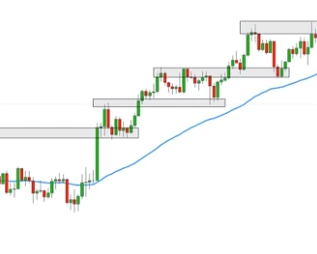
<center>
    <b>Figure 1</b> - The start of an up trend.
</center>

**Down Trend**
Vice versa, the condition for a down trend is triggered after:
1) A dip below the M.A. is detected at price $C_{dip}$.
2) Afterwards, another dip below the M.A. is detected, with price lower than $C_{dip}$.

Should look somewhat like this:

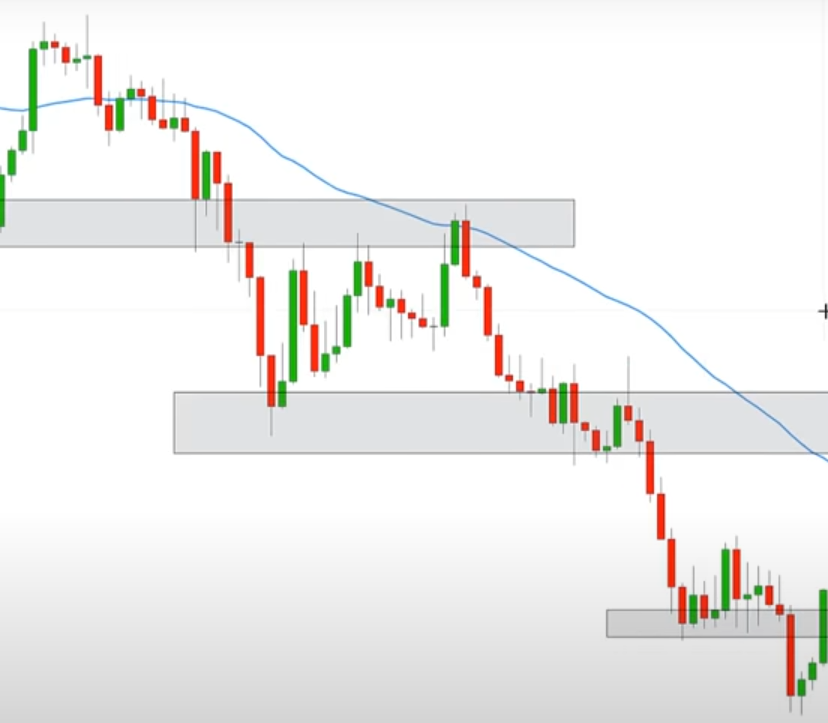
<center>
    <b>Figure 2</b> - The start of down trend.
</center>

##### Entries:

**Up Trends**:

We look for succesful long trades, therefore an entry now is a **buy**. We denote the price at the latest peak above the M.A. $C_{peak}$. We mark an enviroment $(C_{peak} - \varepsilon, C_{peak} + \varepsilon)$ as the valid for `entry` price range. To confirm this is an `up trend`, we wait for another peak, higher than $C_{peak}$. After the second peak we wait for the price to go into the aforementioned price range and for some `candlestick combination` that indicates a bullish reversal (dip), and the price will go up from here. At this point we enter, after detecting such a combination with proper confirmation. In the case of a long trade, we buy.


Candlestick combinations that indicate bullish reversal (down to up):
* Hammer with bullish confirmation.
* 

After detecting such a combination with proper confirmation, we enter. In the case of a long trade, we buy.

**Down Trends**:

We look for succesful short trades, therefore an entry now is a **sell**. We denote the price at the latest dip below the M.A. $C_{dip}$. We mark an enviroment $(C_{dip} - \varepsilon, C_{dip} + \varepsilon)$ as the valid for `entry` price range. To confirm this is an `down trend`, we wait for another dip, lower than $C_{dip}$. After the second dip we wait for the price to go into the aforementioned price range and for some `candlestick combination` that indicates a bearish reversal (peak), and the price will go down from here. At this point we enter, after detecting such a combination with proper confirmation. In the case of a short trade, we sell.


Candlestick combinations that indicate bearish reversal (up to down):
* Shooting Star with bearish confirmation.
* A bullish candle, a bearish engulfing candle and another bearish candle.

##### Stops and Targets

Set the `target` at some resonable price. If shorting, the `target` is below the entry price and when the `target` is reached we buy again.

The `stop` should be set such the difference between the entry price and the `stop` price is a half of the difference between the entry price and the `target` price.

For example, we enter long at 100, we set the target at 110, therfore the stop should be at 95.

#### Code

##### Setup

In [3]:
from modules.tools import pattern_detection
from modules import utils
from modules.utils import bullish_reversal, bearish_reversal

In [4]:
# dir(pattern_detection)

In [5]:
func_name_list = [
    'is_bullish_engulfing',
    'is_hammer',
]
bull_rev_pattern_list = [getattr(pattern_detection, name) for name in func_name_list]
# bull_rev_pattern_list

##### The Strategy

In [6]:
from scipy.signal import find_peaks

class TrendCapture(Strategy):
    
    # ma_len = 50   # when looking for peaks above the M.A., how many bins the M.A. is calculated on.
    # peak_width = 5  # how many bins wide a peak has to have in order to be recognized  
    
    ma_len = 60   # when looking for peaks above the M.A., how many bins the M.A. is calculated on.
    peak_width = 3  # how many bins wide a peak has to have in order to be recognized  
    
    def init(self):
        price = self.data.Close
        self.ma = self.I(SMA, price, self.ma_len)
        
        
        
    def next(self):
        sig = self.data.Close
        peaks_loc, peaks_info = find_peaks(sig, width=self.peak_width)
        dips_loc, dips_info = find_peaks(-sig, width=self.peak_width)

        # IS UP-TREND?
        latest_peak = None
        peaks_abv_ma = 0
        for i in range(len(peaks_loc)):
            cur_peak = peaks_loc[-i-1]  # starts from -1, goes to -len(peaks_loc)

            # is this peak above the MA?
            if self.ma[cur_peak] < sig[cur_peak]:
                peaks_abv_ma += 1

                # the last two peaks have been above the MA & the more recent peak is higher
                if peaks_abv_ma == 2 and sig[latest_peak] > sig[cur_peak]:
                    break
                # keep looking for a pair of consecutive peaks that fit the aboce criteria
                else:
                    peaks_abv_ma = 1
                    latest_peak = cur_peak
            else:
                peaks_abv_ma = 0

        # IS DOWN-TREND?
        latest_dip = None
        dips_blw_ma = 0
        for i in range(len(dips_loc)):
            cur_dip = dips_loc[-i-1]  # starts from -1, goes to -len(peaks_loc)

            # is this dip below the MA?
            if self.ma[cur_dip] > sig[cur_dip]:
                dips_blw_ma += 1

                # the last two dips have been below the MA & the more recent dip is lower
                if dips_blw_ma == 2 and sig[latest_dip] < sig[cur_dip]:
                    break
                # keep looking for consecutive peaks that fit the aboce criteria
                else:
                    dips_blw_ma = 1
                    latest_dip = cur_dip
            else:
                dips_blw_ma = 0


        '''
        certainly: latest_dip != latest_peak (latest dip must be below MA, peak must be above,
        cant happen together).

        Therefore the signal is in one of the following two states:
        1. Down Trend: latest_dip > latest_peak
        1. Up Trend:   latest_dip < latest_peak
        
        HOWEVER, one of them, or both, can be None
        '''
        if latest_dip is None and latest_peak is not None:
            up_trend = True
            down_trend = False
        elif latest_dip is not None and latest_peak is None:
            down_trend = True
            up_trend = False
        elif latest_dip is None and latest_peak is None:
            return None
        else:
            down_trend = latest_dip > latest_peak
            up_trend = not down_trend

        entry_price_loc = latest_dip if down_trend else latest_peak

        # determine valid entry prices
        entry_price = sig[entry_price_loc]
        entry_price_sleeve_thickness = 0.1 * entry_price

        should_enter = sig[-1] > entry_price - entry_price_sleeve_thickness and sig[-1] < entry_price + entry_price_sleeve_thickness

        if should_enter and down_trend:
            
            final_decision = bearish_reversal(
                self.data.df,
                # bull_rev_patterns = [is_hammer, is_bullish_engulfing],
                max_bear_without_pattern = 3,
            )
            
            if final_decision: self.sell()
        elif should_enter and up_trend:
            
            final_decision = bullish_reversal(
                self.data.df,
                # bull_rev_patterns = [is_hammer, is_bullish_engulfing],
                max_bull_without_pattern = 3,
            )
            
            if final_decision: self.buy()    
        # else:
            # keep


#### experiment

In [7]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.close('All')

In [8]:
plt.close('all')
sig = data.High.values
plt.figure()
plt.plot(sig, label='Signal')

ma = SMA(sig, 50)

plt.plot(ma, label='M.A.')

peak_width=5
peaks_loc, peaks_info = find_peaks(sig, width=peak_width)
dips_loc, dips_info = find_peaks(-sig, width=peak_width)

latest_peak = None
peaks_abv_ma = 0
for i in range(len(peaks_loc)):
    cur_peak = peaks_loc[-i-1]  # starts from -1, goes to -len(peaks_loc)
    
    # is this peak above the MA?
    if ma[cur_peak] < sig[cur_peak]:
        peaks_abv_ma += 1
        
        # the last two peaks have been above the MA & the more recent peak is higher
        if peaks_abv_ma == 2 and sig[latest_peak] > sig[cur_peak]:
            break
        # keep looking for a pair of consecutive peaks that fit the aboce criteria
        else:
            peaks_abv_ma = 1
            latest_peak = cur_peak
    else:
        peaks_abv_ma = 0
    
    
        

latest_dip = None
dips_blw_ma = 0
for i in range(len(dips_loc)):
    cur_dip = dips_loc[-i-1]  # starts from -1, goes to -len(peaks_loc)
    
    # is this dip below the MA?
    if ma[cur_dip] > sig[cur_dip]:
        dips_blw_ma += 1
        
        # the last two dips have been below the MA & the more recent dip is lower
        if dips_blw_ma == 2 and sig[latest_dip] < sig[cur_dip]:
            break
        # keep looking for consecutive peaks that fit the aboce criteria
        else:
            dips_blw_ma = 1
            latest_dip = cur_dip
    else:
        dips_blw_ma = 0

        
'''
certainly: latest_dip != latest_peak (latest dip must be below MA, peak must be above,
cant happen together).

Therefore the signal is in one of the following two states:
1. Down Trend: latest_dip > latest_peak
1. Up Trend:   latest_dip < latest_peak
'''
down_trend = latest_dip > latest_peak
up_trend = not down_trend
   
entry_price_loc = max(latest_dip, latest_peak)
    
# determine valid entry prices
entry_price = sig[entry_price_loc]
entry_price_sleeve_thickness = 0.1 * entry_price
    
should_enter = sig[-1] > entry_price - entry_price_sleeve_thickness and sig[-1] < entry_price + entry_price_sleeve_thickness

# print(latest_peak)
# print(latest_dip)

plt.plot(peaks_loc, sig[peaks_loc], linestyle='None', marker = 'v', c='red', alpha=0.1, label='All Peaks')
plt.plot(dips_loc, sig[dips_loc], linestyle='None', marker = '^', c='green', alpha=0.1, label='All Dips')

plt.plot(latest_peak, sig[latest_peak], linestyle='None', marker = 'v', c='red', label='Last Peak')
plt.plot(latest_dip, sig[latest_dip], linestyle='None', marker = '^', c='green', label='Last Dip')

plt.legend()

NameError: name 'data' is not defined

### Moving AVGs

In [9]:
class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()




## IBS

In [10]:
eps = 1e-10

class IbsSolo(Strategy):
    
    th_high_IBS=0.8
    th_low_IBS=0.2
    
    
    def init(self):
        pass
    
    def next(self):
        close = self.data.Close
        low = self.data.Low
        high = self.data.High
        
        IBS = (close - low)/(high - low)
        
        if IBS > self.th_high_IBS:
            size = np.clip((IBS[-1] - self.th_high_IBS)/self.th_high_IBS, eps,1-eps)
            self.sell(size=size)
        elif IBS < self.th_low_IBS:
            size = np.clip((self.th_low_IBS - IBS[-1])/self.th_low_IBS, eps, 1-eps)
            self.buy(size=size)
    
    
class IbsSma(Strategy):
    
    th_high_IBS=0.8
    th_low_IBS=0.2
    ma_len=25
    
    
    def init(self): 
        close = self.data.Close
        self.ma = self.I(SMA, close, self.ma_len)
    
    def next(self):
        close = self.data.Close
        low = self.data.Low
        high = self.data.High
        
        IBS = (close - low)/(high - low)
        
        if IBS > self.th_high_IBS:
            size = np.clip((IBS[-1] - self.th_high_IBS)/self.th_high_IBS, eps,1-eps)
            self.sell(size=size)
        elif IBS < self.th_low_IBS and self.ma*1.05 > close:
            size = np.clip((self.th_low_IBS - IBS[-1])/self.th_low_IBS, eps, 1-eps)
            self.buy(size=size)

# The Playground

## Run

##### Symbols Bank

In [11]:
symbol = 'SPY'  # SPYDER S&P 500
symbol = 'AAPL'  # APPLE
symbol = 'MSFT'  # MICROSOFT

# Country ETFs
country_etfs = {
    'usa': 'SPY',  # SPYDER S&P 500 - USA
    'israel': 'ISRA',  # VanEck Israel ETF
    
}

symbol = 'ILS=X'  # how many ILS is A USD
symbol = 'EUR=X'  # how many Euro is A USD

##### Data

In [ ]:
start = '2019-01-01'
end = '2021-01-01'
interval = '1d'
symbol = 'AAPL'  # how many Euro is A USD

data = yf.download(symbol, start=start, interval=interval)

Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\users\tomhe\appdata\local\programs\python\python38\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\tomhe\appdata\local\programs\python\python38\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\tomhe\appdata\local\programs\python\python38\lib\site-packages\multitasking\__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "c:\users\tomhe\appdata\local\programs\python\python38\lib\site-packages\yfinance\multi.py", line 191, in _download_one_threaded
    data = _download_one(ticker, start, end, auto_adjust, back_adjust,
  File "c:\users\tomhe\appdata\local\programs\python\python38\lib\site-packages\yfinance\multi.py", line 205, in _download_one
    return Ticker(ticker).history(period=period, interval=interval,
  File "c:\users\tomhe\appdata\local\programs\python\python38\lib\site-packages\yfinance\base.

##### Run

In [ ]:
# strategy = IbsSolo
# strategy = SmaCross
# strategy = IbsSma

strategy = TrendCapture
strategy.ma_len = 60
strategy.peak_width = 3

bt = Backtest(data, strategy, commission=.002,
              exclusive_orders=True)
stats = bt.run()

##### Plot

In [ ]:
bt.plot()

##### Stats

In [ ]:
stats

### Optimize

In [ ]:
# best_stats, heatmap = bt.optimize(th_high_IBS=list(np.linspace(0.7, 0.99, 5)), th_low_IBS=list(np.linspace(0.3, 0.01, 5)), return_heatmap=True)
best_stats, heatmap = bt.optimize(ma_len=[25, 40, 50, 55, 60, 70, 100, 125, 150], peak_width=[3, 5, 7, 10], maximize='Return [%]', return_heatmap=True)

In [ ]:
np.argmax(heatmap), heatmap.iloc[np.argmax(heatmap)]

In [ ]:
backtesting.lib.plot_heatmaps(heatmap)

In [ ]:
best_stats